The purpose of this notebook is to layout the different ways of counting genes that are both unknown and essential in M. tuberculosis

### importing libraries

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from random import random
import matplotlib
matplotlib.rc('text', usetex = False)

### setting paths and file names

In [2]:
# unknown categorization
dir_data = '../../data/'
dir_annotations = os.path.join(dir_data, 'annotations')
file_sanger = 'H37Rv_sanger_roles.xlsx'
file_COG = 'H37Rv_COG_mapping.xlsx'
file_tuber = 'Mycobacterium_tuberculosis_H37Rv_txt_v3.xlsx'


## Function definitions:

In [3]:
def essential_subset(df, subset_cols, subset_name):
    df_temp = df[['Rv_ID', 'gene_name']+subset_cols].copy()
    df_temp[subset_name] = df_temp.sum(numeric_only=True, axis = 1)
    
    df_temp.sort_values(by=subset_name, ascending=False, inplace=True)
    df_temp.reset_index(inplace=True, drop=True)
    df_temp = df_temp[['Rv_ID', 'gene_name', subset_name] + subset_cols]
    
    return df_temp

In [4]:
# modify so that you can take a score of a subset of columns, and keep the rest of the columns. 

def score_subset(df, subset_cols, subset_name):
    df_temp = df[['Rv_ID', 'gene_name']+subset_cols].copy()
    df_temp[subset_name] = df_temp.sum(numeric_only=True, axis = 1)
    
    df_temp.sort_values(by=subset_name, ascending=False, inplace=True)
    df_temp.reset_index(inplace=True, drop=True)
    df_temp = df_temp[['Rv_ID', 'gene_name', subset_name] + subset_cols]
    
    return df_temp

def score_subset_keep_rest(df, subset_cols, subset_name):
    df_temp = df[['Rv_ID', 'gene_name']+subset_cols].copy()
    df[subset_name] = df_temp.sum(numeric_only=True, axis = 1)
    
    df.sort_values(by=subset_name, ascending=False, inplace=True)
    df.reset_index(inplace=True, drop=True)
    # df = df[['Rv_ID', 'gene_name', subset_name] + subset_cols]
    
    return df


# labeling genes as "unknown"

In [5]:
# according to Sanger labels
df_sanger = pd.read_excel(os.path.join(dir_annotations, file_sanger))
df_sanger_UK = df_sanger[(df_sanger.sanger == 'V') | (df_sanger.sanger == 'VI')]

# According to COG database
df_COG = pd.read_excel(os.path.join(dir_annotations, file_COG))
df_COG_UK = df_COG[ (df_COG.COG.str.contains('S')) | (df_COG.COG.str.contains('R')) & (df_COG.Rv_ID.str.contains('Rv'))]

# According to Tuberculist: 
df_tuber = pd.read_excel(os.path.join(dir_annotations, file_tuber))
df_tuber = df_tuber[df_tuber.Feature=='CDS']
df_tuber = df_tuber[['Rv_ID', 'Name', 'Function', 'Product', 'Functional_Category']]
df_tuber.dropna(subset = ['Function'], inplace=True)
df_tuber_UK = df_tuber[df_tuber.Function.str.contains('unknown', case = False)]
df_tuber_UK_byname = df_tuber[df_tuber.Rv_ID == df_tuber.Name]

#### printing out the numbers

In [6]:
print('number of Sanger unknowns:', df_sanger_UK.shape[0])
print('number of COG unknowns:', df_COG_UK.shape[0])
print('number of Tuberculist/Mycobrowser unknowns:', df_tuber_UK.shape[0])
print('number of Tuberculist/Mycobrowser unknowns by name:', df_tuber_UK_byname.shape[0])

number of Sanger unknowns: 1521
number of COG unknowns: 2046
number of Tuberculist/Mycobrowser unknowns: 2310
number of Tuberculist/Mycobrowser unknowns by name: 2077


#### make a barplot from this: 

In [8]:
dir_figs = '../../figures/genome_visualizations/'

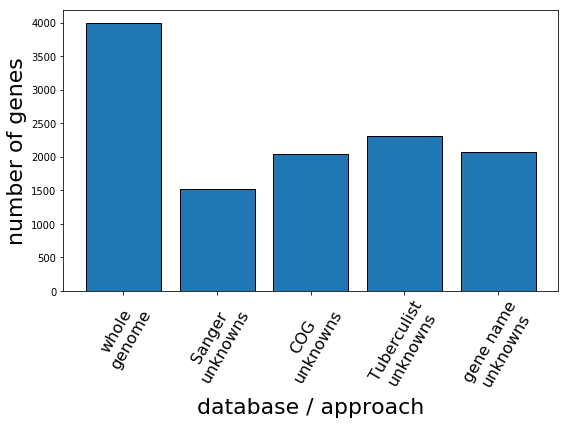

In [9]:
whole_genome = 3990 #Why does this not match *any* of the datasets you're loading? 
bar_heights = [whole_genome, df_sanger_UK.shape[0], df_COG_UK.shape[0], 
               df_tuber_UK.shape[0], df_tuber_UK_byname.shape[0] ]
xtick_labels = ['whole\ngenome', 'Sanger\nunknowns', 'COG\nunknowns', 'Tuberculist\nunknowns', 'gene name\nunknowns']
plt.figure(figsize = (8,6))
plt.bar(range(len(bar_heights)), bar_heights, edgecolor = 'k')
xt = plt.xticks(range(len(bar_heights)), xtick_labels, fontsize = 16, rotation = 60)
plt.xlabel('database / approach', fontsize = 22)
yl = plt.ylabel('number of genes', fontsize = 22)
plt.tight_layout()
outfile = os.path.join(dir_figs, 'unknown_bar.png')
plt.savefig(outfile, dpi=300)

### Follow-up question: how many are unknown according to all databases?

### compiling into dataframe:

In [10]:
file_WG = 'H37Rv_tuberculist_functional_categories.xlsx'
df_WG = pd.read_excel(os.path.join(dir_annotations, file_WG))
df_WG = df_WG[['Rv_ID', 'gene_name']]

In [11]:
# Sanger: 
col_name = 'Sanger_unknown'
df_temp = df_sanger_UK[['Rv_ID']].copy()
df_temp[col_name] = df_temp.shape[0]*[1]
df_temp_WG = df_WG.merge(df_temp, how = 'left', on = 'Rv_ID')
df_temp_WG[col_name].fillna(0, inplace = True)
df_ALL = df_temp_WG.copy()
# COG:
col_name = 'COG_unknown'
df_temp = df_COG_UK[['Rv_ID']].copy()
df_temp[col_name] = df_temp.shape[0]*[1]
df_temp_WG = df_WG.merge(df_temp, how = 'left', on = 'Rv_ID')
df_temp_WG[col_name].fillna(0, inplace = True)
df_ALL = df_ALL.merge(df_temp_WG, how = 'inner', on = ['Rv_ID', 'gene_name'])
# Tuberculist
col_name = 'Tuberculist_unknown'
df_temp = df_tuber_UK[['Rv_ID']].copy()
df_temp[col_name] = df_temp.shape[0]*[1]
df_temp_WG = df_WG.merge(df_temp, how = 'left', on = 'Rv_ID')
df_temp_WG[col_name].fillna(0, inplace = True)
df_ALL = df_ALL.merge(df_temp_WG, how = 'inner', on = ['Rv_ID', 'gene_name'])
# By gene_name
col_name = 'gene_name_unknown'
df_temp = df_tuber_UK_byname[['Rv_ID']].copy()
df_temp[col_name] = df_temp.shape[0]*[1]
df_temp_WG = df_WG.merge(df_temp, how = 'left', on = 'Rv_ID')
df_temp_WG[col_name].fillna(0, inplace = True)
df_ALL = df_ALL.merge(df_temp_WG, how = 'inner', on = ['Rv_ID', 'gene_name'])

In [12]:
unknown_cols = ['Sanger_unknown', 'COG_unknown', 'Tuberculist_unknown', 'gene_name_unknown'] 
score_name = 'unknown_score'
df_ALL_score = score_subset(df_ALL, unknown_cols, score_name)
# df_ALL_score['unknown_score'] = [int(s) for s in df_master.unknown_score.values]

In [13]:
df_ALL_score.head(2)

,Rv_ID,gene_name,unknown_score,Sanger_unknown,COG_unknown,Tuberculist_unknown,gene_name_unknown
0,Rv1927,-,4.0,1.0,1.0,1.0,1.0
1,Rv1744c,-,4.0,1.0,1.0,1.0,1.0


### Can we score according to only a subset of columns? 

In [14]:
# one column
unknown_cols = ['Sanger_unknown'] 
score_name = 'UK_score_1'
df_UK_score_1 = score_subset(df_ALL, unknown_cols, score_name)
# two columns 
unknown_cols = ['Sanger_unknown', 'COG_unknown'] 
score_name = 'UK_score_2'
df_UK_score_2 = score_subset(df_ALL, unknown_cols, score_name)
# three columns
unknown_cols = ['Sanger_unknown', 'COG_unknown', 'Tuberculist_unknown'] 
score_name = 'UK_score_3'
df_UK_score_3 = score_subset(df_ALL, unknown_cols, score_name)
# four columns
unknown_cols = ['Sanger_unknown', 'COG_unknown', 'Tuberculist_unknown', 'gene_name_unknown'] 
score_name = 'UK_score_4'
df_UK_score_4 = score_subset(df_ALL, unknown_cols, score_name)

In [15]:
df_UK_score_ALL = df_UK_score_2.merge(df_UK_score_1, how = 'left', on = ['Rv_ID', 'gene_name' ,'Sanger_unknown'])
df_UK_score_ALL = df_UK_score_ALL.merge(df_UK_score_3, how = 'left', on = ['Rv_ID', 'gene_name' ,'Sanger_unknown', 'COG_unknown'])
df_UK_score_ALL = df_UK_score_ALL.merge(df_UK_score_4, how = 'left', on = ['Rv_ID', 'gene_name' ,'Sanger_unknown', 'COG_unknown', 'Tuberculist_unknown'])
df_UK_score_ALL = df_UK_score_ALL[['Rv_ID', 'gene_name', 'Sanger_unknown', 'COG_unknown', 'Tuberculist_unknown', 'gene_name_unknown', 'UK_score_1', 'UK_score_2', 'UK_score_3', 'UK_score_4']]

In [16]:
df_UK_score_ALL.head(3)

,Rv_ID,gene_name,Sanger_unknown,COG_unknown,Tuberculist_unknown,gene_name_unknown,UK_score_1,UK_score_2,UK_score_3,UK_score_4
0,Rv2762c,-,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0
1,Rv2137c,-,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0
2,Rv2076c,-,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0


### Visualize based just on unknown score: 

In [17]:
UK_score_1 = df_UK_score_ALL.UK_score_1.values
rand_param = 0.75
UK_score_1_rd = [uk + rand_param*random()-rand_param/2 for uk in UK_score_1]
RAND_Y = [random() for i in range(len(UK_score_1_rd))]

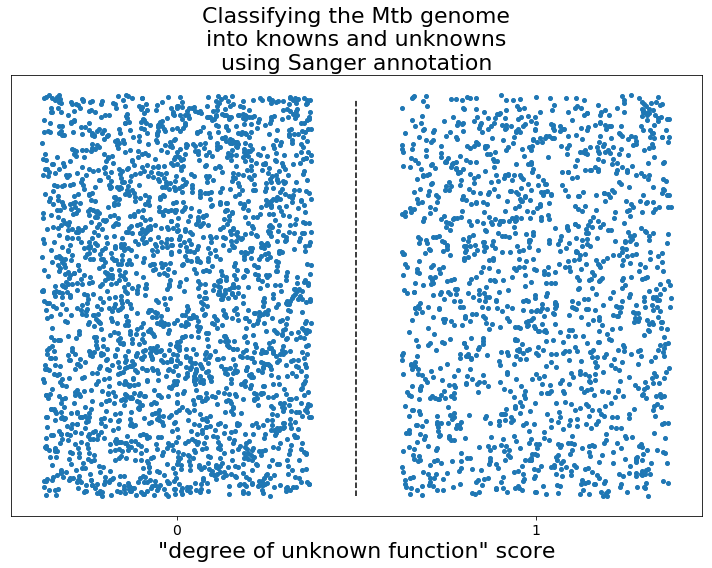

In [18]:
fig, ax = plt.subplots(figsize = (10,8))

ax.plot(UK_score_1_rd, RAND_Y, 'o', markersize = 4)

yvals = np.arange(0, 1, 0.01)
xvals = len(yvals)*[0.5]
ax.plot(xvals, yvals, '--', color = "k")

plt.xlabel('\"degree of unknown function\" score', fontsize = 22)
plt.xticks([0, 1], fontsize = 14)
yt = plt.yticks([])

tt = plt.title('Classifying the Mtb genome\ninto knowns and unknowns\nusing Sanger annotation', fontsize = 22)
plt.tight_layout()
out_file = os.path.join(dir_figs, 'uknowns_v1.png')
plt.savefig(out_file, dpi=200)

In [19]:
UK_score_1 = df_UK_score_ALL.UK_score_1.values
rand_param = 0.5
UK_score_1_rd = [uk + rand_param*random()-rand_param/2 for uk in UK_score_1]
RAND_theta = [2 * np.pi*random() for i in range(len(UK_score_1_rd))]

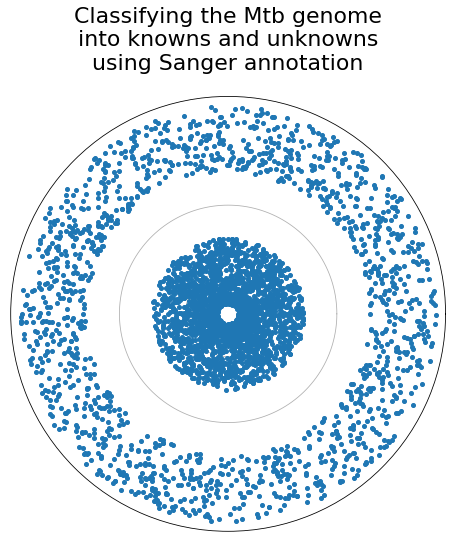

In [20]:
plt.figure(figsize = (10,8))
ax = plt.subplot(111, projection='polar')
ax.plot(RAND_theta, UK_score_1_rd,  'o', markersize = 4)
ax.set_rticks([0, 0.5], )
ax.set_yticklabels(['', ''], fontsize = 20)
ax.set_thetagrids([])
tt = plt.title('Classifying the Mtb genome\ninto knowns and unknowns\nusing Sanger annotation', fontsize = 22)

In [21]:
UK_score_2 = df_UK_score_ALL.UK_score_2.values
rand_param = 0.75
UK_score_2_rd = [uk + rand_param*random()-rand_param/2 for uk in UK_score_2]

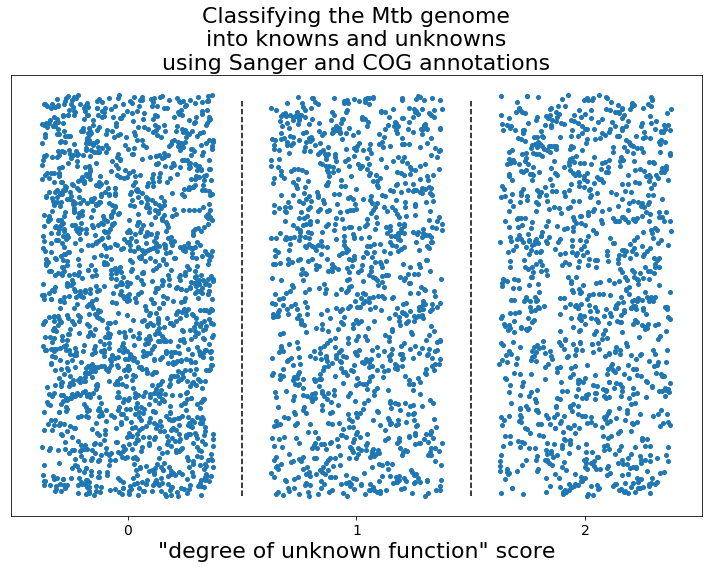

In [22]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(UK_score_2_rd, RAND_Y, 'o', markersize = 4)
for x in np.arange(0.5, 2.5, 1):
    yvals = np.arange(0, 1, 0.01)
    xvals = len(yvals)*[x]
    ax.plot(xvals, yvals, '--', color = "k")
plt.xlabel('\"degree of unknown function\" score', fontsize = 22)
plt.xticks([0, 1, 2], fontsize = 14)
yt = plt.yticks([])
tt = plt.title('Classifying the Mtb genome\ninto knowns and unknowns\nusing Sanger and COG annotations', fontsize = 22)
plt.tight_layout()
out_file = os.path.join(dir_figs, 'uknowns_v2.png')
plt.savefig(out_file, dpi=200)


In [23]:
UK_score_3 = df_UK_score_ALL.UK_score_3.values
rand_param = 0.75
UK_score_3_rd = [uk + rand_param*random()-rand_param/2 for uk in UK_score_3]

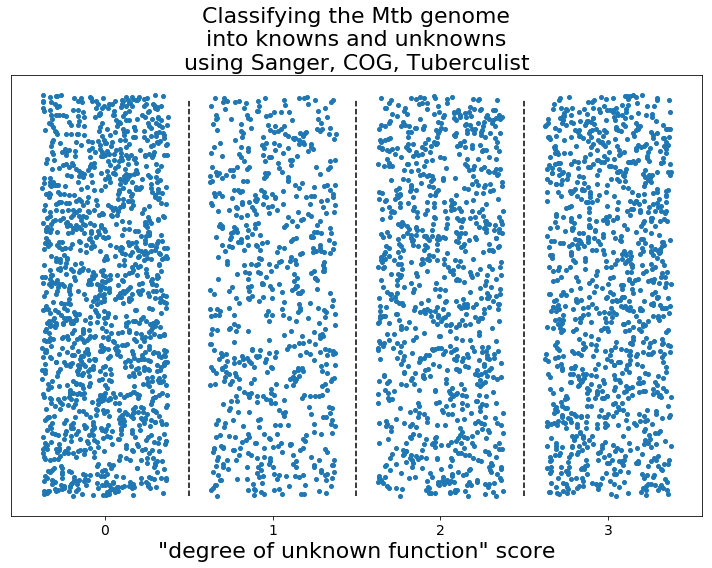

In [24]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(UK_score_3_rd, RAND_Y, 'o', markersize = 4)
for x in np.arange(0.5, 3.5, 1):
    yvals = np.arange(0, 1, 0.01)
    xvals = len(yvals)*[x]
    ax.plot(xvals, yvals, '--', color = "k")
plt.xlabel('\"degree of unknown function\" score', fontsize = 22)
plt.xticks([0, 1, 2, 3], fontsize = 14)
yt = plt.yticks([])
tt = plt.title('Classifying the Mtb genome\ninto knowns and unknowns\nusing Sanger, COG, Tuberculist', fontsize = 22)
plt.tight_layout()
out_file = os.path.join(dir_figs, 'uknowns_v3.png')
plt.savefig(out_file, dpi=200)

In [25]:
UK_score_4 = df_UK_score_ALL.UK_score_4.values
rand_param = 0.75
UK_score_4_rd = [uk + rand_param*random()-rand_param/2 for uk in UK_score_4]

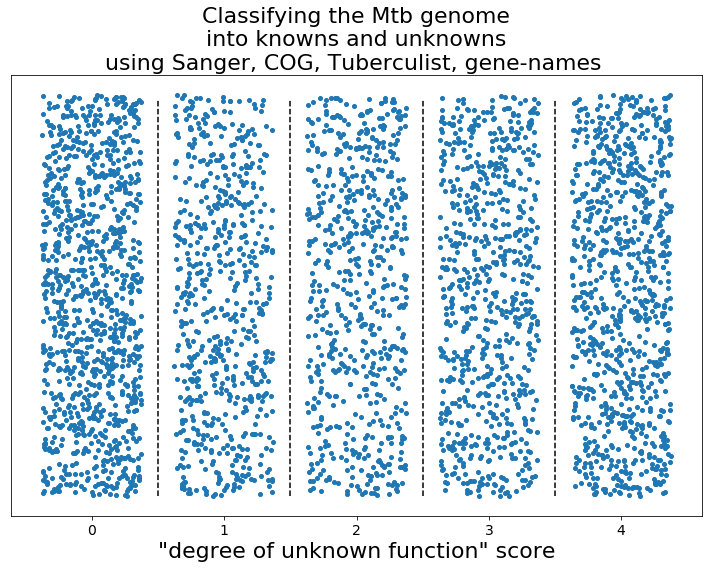

In [26]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(UK_score_4_rd, RAND_Y, 'o', markersize = 4)
for x in np.arange(0.5, 4.5, 1):
    yvals = np.arange(0, 1, 0.01)
    xvals = len(yvals)*[x]
    ax.plot(xvals, yvals, '--', color = "k")
plt.xlabel('\"degree of unknown function\" score', fontsize = 22)
plt.xticks([0, 1, 2, 3, 4], fontsize = 14)
yt = plt.yticks([])
tt = plt.title('Classifying the Mtb genome\ninto knowns and unknowns\nusing Sanger, COG, Tuberculist, gene-names ', fontsize = 22)
plt.tight_layout()
out_file = os.path.join(dir_figs, 'uknowns_v4.png')
plt.savefig(out_file, dpi=200)

# Personal challenge: Make a (useful) plot that's inpired by Hans Rosling's bubble plots

# Labeling genes as "in vitro essential"

In [27]:
# essential categorization
tn_file = 'Tn_library_DB.xlsx'

In [28]:
df_tn = pd.read_excel(os.path.join(dir_data, tn_file))
df_tn.shape

(3990, 60)

In [29]:
in_vitro_growth_cols = ["2003A_Sassetti", "2012_Zhang", "2013_DeJesus", "2017A_DeJesus"]

In [30]:
df_tn_iv_0 = df_tn[df_tn[in_vitro_growth_cols[0]]==1]
df_tn_iv_1 = df_tn[df_tn[in_vitro_growth_cols[1]]==1]
df_tn_iv_2 = df_tn[df_tn[in_vitro_growth_cols[2]]==1]
df_tn_iv_3 = df_tn[df_tn[in_vitro_growth_cols[3]]==1]

In [31]:
print('Essentials according to Sassetti et al. (2003):', df_tn_iv_0.shape[0])
print('Essentials according to Zhang et al. (2012):', df_tn_iv_1.shape[0])
print('Essentials according to De Jesus et al. (2013):', df_tn_iv_2.shape[0])
print('Essentials according to De Jesus et al. (2017):', df_tn_iv_3.shape[0])

Essentials according to Sassetti et al. (2003): 614
Essentials according to Zhang et al. (2012): 742
Essentials according to De Jesus et al. (2013): 667
Essentials according to De Jesus et al. (2017): 625


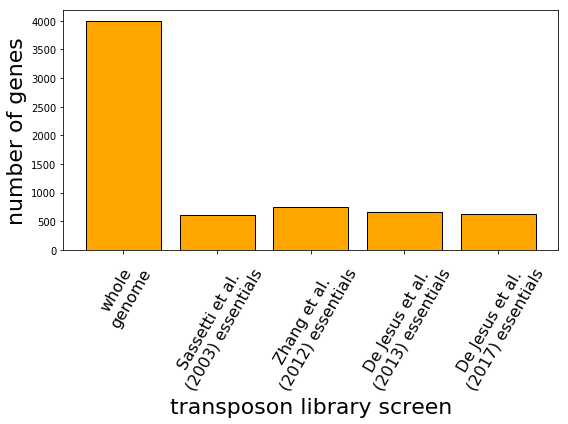

In [33]:
whole_genome = 3990 #Why does this not match *any* of the datasets you're loading? 
bar_heights = [whole_genome, df_tn_iv_0.shape[0], df_tn_iv_1.shape[0], 
               df_tn_iv_2.shape[0], df_tn_iv_3.shape[0] ]
xtick_labels = ['whole\ngenome', 'Sassetti et al.\n(2003) essentials', 
                'Zhang et al.\n(2012) essentials', 'De Jesus et al.\n(2013) essentials', 
                'De Jesus et al.\n(2017) essentials']
plt.figure(figsize = (8,6))
plt.bar(range(len(bar_heights)), bar_heights, edgecolor = 'k', color = 'orange')
xt = plt.xticks(range(len(bar_heights)), xtick_labels, fontsize = 16, rotation = 60)
plt.xlabel('transposon library screen', fontsize = 22)
yl = plt.ylabel('number of genes', fontsize = 22)
plt.tight_layout()
out_file = os.path.join(dir_figs, 'essentials_bar.png')
plt.savefig(out_file, dpi=200)

# Calculating essentiality and unknown function scores for every gene in H37Rv

In [34]:
df_tn_iv = df_tn[['Rv_ID', 'gene_name']+in_vitro_growth_cols]
df_tn_iv.shape

(3990, 6)

In [35]:
df_tn_iv = essential_subset(df_tn_iv, in_vitro_growth_cols, 'in_vitro_score')

In [36]:
df_tn_iv.head(2)

,Rv_ID,gene_name,in_vitro_score,2003A_Sassetti,2012_Zhang,2013_DeJesus,2017A_DeJesus
0,Rv0001,dnaA,4,1,1,1,1
1,Rv3582c,ispD,4,1,1,1,1


In [37]:
for i in range(5):
    print(df_tn_iv[df_tn_iv.in_vitro_score == i].shape[0], 'genes are called essential in', i, 'out of the 4 in vitro glycerol screens')

2900 genes are called essential in 0 out of the 4 in vitro glycerol screens
382 genes are called essential in 1 out of the 4 in vitro glycerol screens
183 genes are called essential in 2 out of the 4 in vitro glycerol screens
200 genes are called essential in 3 out of the 4 in vitro glycerol screens
325 genes are called essential in 4 out of the 4 in vitro glycerol screens


# Merge to include unknown and essentiality scores: 

In [38]:
df_master = df_tn_iv.merge(df_UK_score_ALL, how = 'inner', on = ['Rv_ID', 'gene_name'])

In [39]:
out_file = 'unknown_ALL_levels_essential_scores.csv'
out_file = os.path.join(dir_data, 'unknown_essentials', out_file)
df_master.to_csv(out_file, index = False)

# Objective: Draw in polar coordinates a partition of the TB genome into (i) unknown scores, and (ii) conditional essentiality categories.

In [40]:
essential_cutoff = 2
df_essential = df_master[df_master.in_vitro_score >= essential_cutoff]
df_non_essential = df_master[df_master.in_vitro_score < essential_cutoff]
df_essential.shape

(708, 15)

In [41]:
rand_param = 0.5
angle = 2*np.pi  * (df_essential.shape[0]) / (df_master.shape[0])

In [42]:
# set 1 (essentials)
UK_scores_set_1 = df_essential.UK_score_4.values
UK_scores_set_1_rd = [uk + rand_param*random()-rand_param/2 for uk in UK_scores_set_1]
RAND_theta_set_1 = [ angle*random() for i in range(len(UK_scores_set_1_rd))]
# set 2 (non-essentials)
UK_scores_set_2 = df_non_essential.UK_score_4.values
UK_scores_set_2_rd = [uk + rand_param*random()-rand_param/2 for uk in UK_scores_set_2]
RAND_theta_set_2 = [ (2*np.pi - angle)*random() + angle for i in range(len(UK_scores_set_2_rd))]

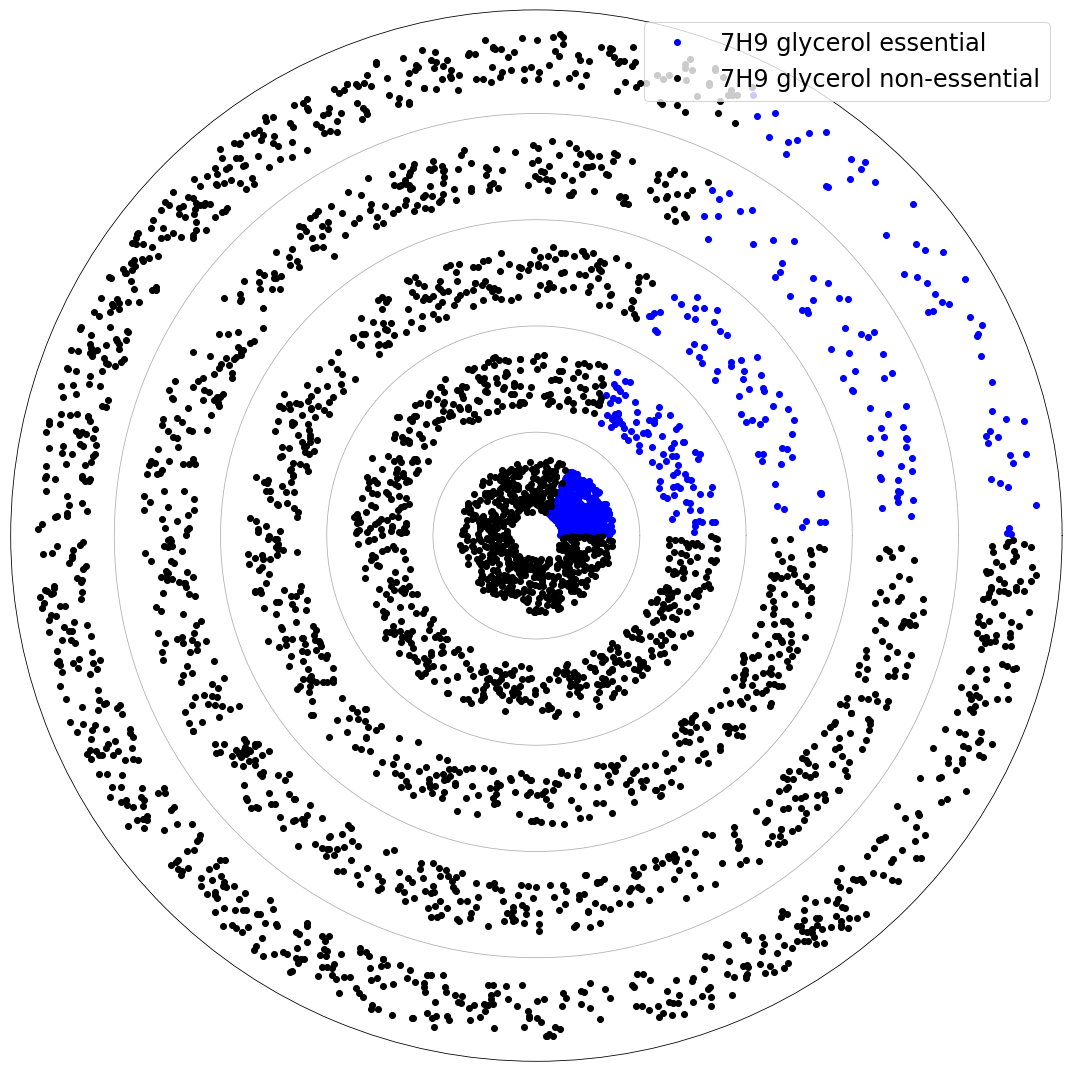

In [43]:
plt.figure(figsize = (15,15))
ax = plt.subplot(111, projection='polar')

ax.plot(RAND_theta_set_1, UK_scores_set_1_rd,  'o', color = 'blue', markersize = 6)
ax.plot(RAND_theta_set_2, UK_scores_set_2_rd,  'o', color = 'black', markersize = 6)

plt.legend(['7H9 glycerol essential', '7H9 glycerol non-essential'], fontsize = 24, loc = 1)
ax.set_yticks([0.5, 1.5, 2.5, 3.5])
ax.set_yticklabels([''], fontsize = 15)
ax.set_thetagrids([])
# tt = plt.title('Classifying the $M. tuberculosis$ genome\ninto knowns and unknowns', fontsize = 30)
plt.tight_layout()
outfile = os.path.join(dir_figs, 'Polar_UK_essential_score.png')
plt.savefig(outfile, dpi = 200) 

# Repeat, but subdividing the circle into many more categories
Take the categories from the tSNE plot

In [44]:
cols_to_use = df_tn.columns.difference(df_master.columns)

In [45]:
df_tn_score = pd.merge(df_master, df_tn[cols_to_use], left_index=True, right_index=True, how = 'inner')

In [46]:
tn_all = df_tn.columns.tolist()[2:]
df_tn_score = score_subset_keep_rest(df_tn_score, tn_all, 'all_Tn_score')

Define the categories: 
(automate all of this please!)

In [47]:
Rv_list_temp = []
#zeros across all Tn-Matrix columns
df_zeros = df_tn_score[df_tn_score.all_Tn_score == 0] 
Rv_list_temp += list(df_zeros.Rv_ID)


# glycerol essential
essential_cutoff = 3
df_7H9_glycerol = df_tn_score[df_tn_score.in_vitro_score >= essential_cutoff]
Rv_list_temp += list(df_7H9_glycerol.Rv_ID)

# Mouse, 2013_Zhang_3A
df_mouse = df_tn_score[ df_tn_score['2013_Zhang_1']==1 ]
df_mouse = df_mouse[~df_mouse.Rv_ID.isin(Rv_list_temp)]
Rv_list_temp = Rv_list_temp + list(df_mouse.Rv_ID)

# Rv0307c genetic interaction:
df_Rv0307c = df_tn_score[df_tn_score.Rv0307c == 1]
# this fixes the standarization issues that Michael emphasizes
df_Rv0307c = df_Rv0307c[~df_Rv0307c.Rv_ID.isin(Rv_list_temp)]
Rv_list_temp += list(df_Rv0307c.Rv_ID)

# Rv3005c genetic interaction:
df_Rv3005 = df_tn_score[df_tn_score.Rv3005c == 1]
# dirty patch that fixes the standarization issues that Michael emphasizes
df_Rv3005 = df_Rv3005[ ~(df_Rv3005.Rv_ID.isin(Rv_list_temp))]
Rv_list_temp += list(df_Rv3005.Rv_ID)

# all the rest: 
df_rest = df_tn_score[~df_tn_score.Rv_ID.isin(Rv_list_temp)]


In [48]:
# all together: 
Tn_labels = ['7H9 glycerol', 'WT mouse', 'Rv0307c-KO bkg', 'Rv3005c-KO bkg', 'never essential', 'other essentiality\nprofiles']

df_list = [df_7H9_glycerol, df_mouse, df_Rv0307c, df_Rv3005, df_zeros, df_rest]
shape_list = [df.shape[0] for df in df_list]
print(shape_list)
print(np.sum(np.array(shape_list)))

[525, 494, 344, 273, 1284, 1070]
3990


Generate randomized UK scores:

In [49]:
# UNKNOWN scores: 
UK_scores_list = [df['UK_score_4'].values for df in df_list]
UK_scores_rd = []
for uk_scores in UK_scores_list:
    UK_scores_rd.append( [uk + rand_param*random()-rand_param/2 for uk in uk_scores] )

generate the correct / proportional angle distribution

In [50]:
angle_list = [(df.shape[0])/(df_tn_score.shape[0]) * 2*np.pi for df in df_list]

In [51]:
# automate this step
RAND_theta_list = []
sum_angle = 0
for i in range(len(angle_list)):
    RAND_theta_list.append( [ angle_list[i]*random() + sum_angle for j in range(len(UK_scores_rd[i]))] )
    sum_angle += angle_list[i]

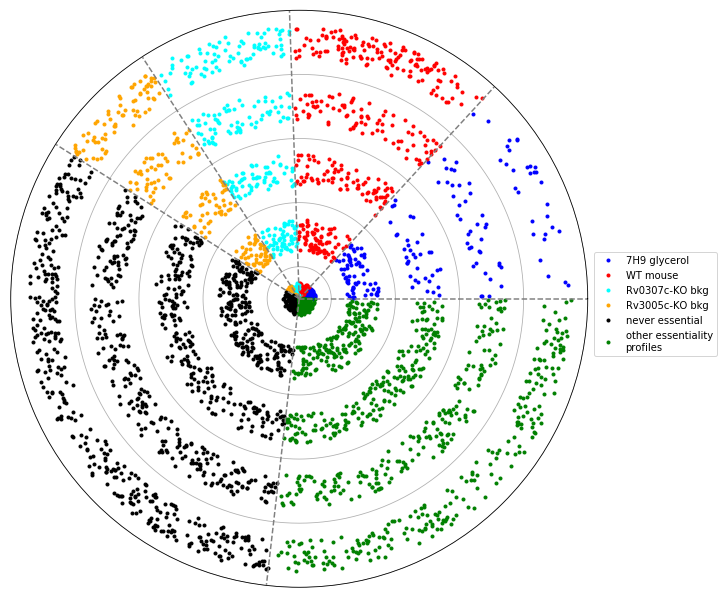

In [53]:
plt.figure(figsize = (10,10))
ax = plt.subplot(111, projection='polar')
color_list = ['blue', 'red', 'cyan', 'orange', 'black', 'green']
Tn_labels = ['7H9 glycerol', 'WT mouse', 'Rv0307c-KO bkg', 'Rv3005c-KO bkg', 'never essential', 'other essentiality\nprofiles']
ms = 3
for i in range(len(df_list)):
    ax.plot(RAND_theta_list[i], UK_scores_rd[i],  'o', color = color_list[i], markersize = ms)


plt.legend(Tn_labels, fontsize = 10, loc = (1.01,0.4))

r_line = np.arange(0, 4.5, 0.01)
sum_angle = 0

for i in range(len(angle_list)):
    plt.plot(len(r_line)*[angle_list[i] + sum_angle], r_line, '--', color = 'grey')
    sum_angle+=angle_list[i] 
    
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
#ax.set_ybound(upper=4.5)
ax.set_ylim(0,4.5)
ax.set_yticklabels([''], fontsize = 15)
ax.set_thetagrids([])
# tt = plt.title('Classifying the $M. tuberculosis$ genome\ninto knowns and unknowns', fontsize = 30)
plt.tight_layout()
outfile = os.path.join(dir_figs, 'Polar_UK_essential_6_cats.png')
plt.savefig(outfile, dpi = 200) 

# Challenge: design an ID-card for each gene! 
1. Unknown function score (and breakdown)
2. list / summary of essentiality calls
3. list of genes in neighborhood (knowns and unknowns)


# Challenge: implement a smooth animation mapping one plot onto the next one (like Bill Gates' presentation)

# A good, original, and refreshing idea: for the large-scale CRISPRi project, make a distance measure between metabolites and genes. 
Each gene is surrounded by a "cloud" of metabolites

# A potential vision: A postdoc focused on designing online visualization-strong tools, involving lots of DJ3 and the like!

# Other next steps: incorporate the rest of the data that Michael shared with you, as well as the microarray data
# Do the neighborhood statistical analysis using e.g. GO terms or other categorization
# Find a candidate gene of unknown function and predict its function based on its neighborhood

# [MIGHT BE OUTDATED] More visualizations:

In [54]:
unknown_score = df_master.UK_score_4.values
invitro_score = df_master.in_vitro_score

Add some random noise: 

In [55]:
rand_param = 0.75
unknown_score_rd = [uk + rand_param*random()-rand_param/2 for uk in unknown_score]
invitro_score_rd = [iv + rand_param*random()-rand_param/2 for iv in invitro_score]

In [56]:
df_master['unknown_score_rd'] = unknown_score_rd
df_master['invitro_score_rd'] = invitro_score_rd

In [64]:
df_master.to_csv('essentials7H9_unknown_levels.csv', index = False)

In [67]:
df_master.head(5)

,Rv_ID,gene_name,in_vitro_score,2003A_Sassetti,2012_Zhang,2013_DeJesus,2017A_DeJesus,Sanger_unknown,COG_unknown,Tuberculist_unknown,gene_name_unknown,UK_score_1,UK_score_2,UK_score_3,UK_score_4,unknown_score_rd,invitro_score_rd
0,Rv0001,dnaA,4,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047603,3.732377
1,Rv3582c,ispD,4,1,1,1,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.316363,4.254044
2,Rv0510,hemC,4,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240841,3.938167
3,Rv0509,hemA,4,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.098502,4.079258
4,Rv0500,proC,4,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.047453,3.886733


In [26]:
# cloned_file = 'phenotypic_screens/cloned_genes_DB.xlsx' # sheet_name = 'selected'
cloned_path = '/Users/ajinich/Dropbox (Personal)/KyuRhee/misc_code/Alex_learning'
cloned_file = os.path.join(cloned_path, 'Gene_library_categories.xlsx')

# CAREFUL: this is missing the set of genes of known function:

In [32]:
df_cloned = pd.read_excel( cloned_file )
df_cloned.dropna(subset=['Rv_ID'], inplace=True)
cloned_genes = [''.join(rv.split('_')) for rv in df_cloned.Rv_ID.unique()]

In [33]:
df_master_cloned = df_master[df_master.Rv_ID.isin(cloned_genes)]

In [34]:
unknown_score_cloned = df_master_cloned.unknown_score_rd.values
invitro_score_cloned = df_master_cloned.invitro_score_rd.values

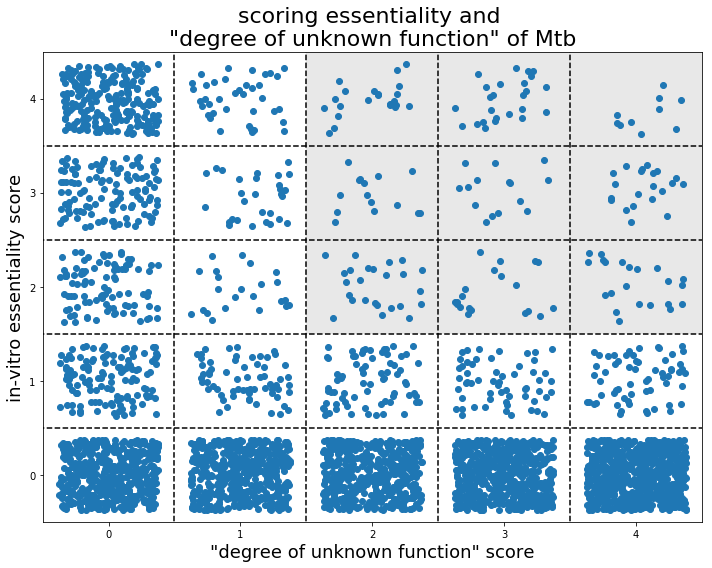

In [53]:
# plt.figure(figsize = (10,8))
fig, ax = plt.subplots(figsize = (10,8))

ax.plot(unknown_score_rd, invitro_score_rd, 'o')
# ax.plot(unknown_score_cloned, invitro_score_cloned, 'ro')

for y in np.arange(0.5, 4.5, 1):
    xvals = np.arange(-1, 5, 0.1)
    yvals = len(xvals)*[y]
    ax.plot(xvals, yvals, '--', color = "k")
    ax.plot(yvals, xvals, '--', color = "k")
plt.xlim(-0.5, 4.5)
plt.ylim(-0.5, 4.5)

x = [1.5, 1.5, 4.5, 4.5]
y = [1.5, 4.5, 4.5, 1.5]
ax.fill(x, y, 'lightgrey', alpha = 0.5)
    
plt.xlabel('\"degree of unknown function\" score', fontsize = 18)
plt.ylabel('in-vitro essentiality score', fontsize = 18)


plt.title('scoring essentiality and \n\"degree of unknown function\" of Mtb', fontsize = 22)

plt.tight_layout()

plt.savefig('essential_unknown_scores_no_cloned.png', dpi = 300)

## Exploring gene lists: for the Hung transposon library of "transposon mutants of non-essential genes"

In [54]:
df_hung = df_master[ (df_master.unknown_score == 4) & 
                          (df_master.in_vitro_score <= 2) ][['Rv_ID', 'gene_name', 
                                                             'in_vitro_score', 'unknown_score']]

In [65]:
df_hung = df_hung.reset_index(drop=True)
df_hung.sort_values('Rv_ID', inplace=True)
df_hung['Rv_ID'].to_excel('hung_transposon_Adrian.xlsx', index = False)

In [71]:
df_hung_plate = pd.read_excel('PlateMapOct2018.xlsx')
df_hung_plate.rename(columns={"Gene": "Rv_ID"}, inplace=True)
df_hung_plate.head(3)

,Plate,Well,Rv_ID
0,TB01,A01,Rv2340c
1,TB01,A02,Rv0407
2,TB01,A05,Rv1859


In [76]:
df_hung_intersect = df_hung_plate.merge(df_hung, how = 'inner', on = 'Rv_ID')
# df_hung_intersect = df_hung_intersect[['Plate', 'Well', 'Rv_ID']]
# df_hung_intersect.to_excel('PlateMapOct2018_Adrian.xlsx', index = False)

In [78]:
df_hung_intersect.head()

,Plate,Well,Rv_ID,gene_name,in_vitro_score,unknown_score
0,TB01,A08,Rv2574,-,0,4.0
1,TB01,B03,Rv1290c,-,0,4.0
2,TB01,B05,Rv2474c,-,1,4.0
3,TB01,B08,Rv2767c,-,0,4.0
4,TB01,C11,Rv2795c,-,0,4.0


### Explore gene lists ranked according to these criteria:  

In [403]:
df_master_top = df_master[ (df_master.unknown_score >= 2) & 
                          (df_master.in_vitro_score >= 2) ][['Rv_ID', 'gene_name', 
                                                             'in_vitro_score', 'unknown_score']]


In [404]:
df_master_top.sort_values(['unknown_score', 'in_vitro_score'], ascending=False, inplace=True)
df_master_top.reset_index(inplace=True, drop=True)
df_master_top.to_excel('Top_unknown_essentials_12_06_2018.xlsx', index = False)
df_master_top.head(30)

,Rv_ID,gene_name,in_vitro_score,unknown_score
0,Rv1459c,-,4,4.0
1,Rv2698,-,4,4.0
2,Rv0347,-,4,4.0
3,Rv1697,-,4,4.0
4,Rv0811c,-,4,4.0
5,Rv3031,-,4,4.0
6,Rv3030,-,4,4.0
7,Rv2164c,-,4,4.0
8,Rv0060,-,4,4.0
9,Rv2235,-,4,4.0


In [405]:
df_master_top_cloned = df_master_top[df_master_top.Rv_ID.isin(cloned_genes)]
df_master_top_cloned.reset_index(inplace=True, drop=True)
df_master_top_cloned.to_excel('Top_unknown_essentials_cloned_12_06_2018.xlsx', index = False)
df_master_top_cloned

,Rv_ID,gene_name,in_vitro_score,unknown_score
0,Rv0811c,-,4,4.0
1,Rv3034c,-,3,4.0
2,Rv0338c,-,4,3.0
3,Rv2971,-,4,3.0
4,Rv3778c,-,4,3.0
5,Rv0412c,-,3,3.0
6,Rv2509,-,3,3.0
7,Rv3712,-,3,3.0
8,Rv3193c,-,2,3.0
9,Rv0955,-,2,3.0


In [35]:
df_master.shape

(3990, 14)

In [273]:
df_master[ (df_master.unknown_score == 4) & (df_master.in_vitro_score ==4) ][['Rv_ID', 'gene_name', 'in_vitro_score', 'unknown_score']]

,Rv_ID,gene_name,in_vitro_score,unknown_score
40,Rv1459c,-,4,4.0
62,Rv2698,-,4,4.0
91,Rv0347,-,4,4.0
110,Rv1697,-,4,4.0
122,Rv0811c,-,4,4.0
139,Rv3031,-,4,4.0
140,Rv3030,-,4,4.0
251,Rv2164c,-,4,4.0
262,Rv0060,-,4,4.0
306,Rv2235,-,4,4.0


### Find all genes that are both unknown (s>2) and essential (s>2) 

In [264]:
df_master_cloned[ (df_master_cloned.unknown_score >= 2) & (df_master_cloned.in_vitro_score >= 3) ][['Rv_ID', 'gene_name', 'in_vitro_score', 'unknown_score']]

,Rv_ID,gene_name,in_vitro_score,unknown_score
89,Rv0338c,-,4,3.0
222,Rv0697,-,4,2.0
240,Rv2361c,-,4,2.0
256,Rv2182c,-,4,2.0
269,Rv2477c,-,4,2.0
290,Rv3778c,-,4,3.0
316,Rv0224c,-,4,2.0
324,Rv0228,-,4,2.0
379,Rv0526,-,3,2.0
406,Rv3032,-,3,2.0


In [265]:
df_master_cloned[ (df_master_cloned.unknown_score >= 2) & (df_master_cloned.in_vitro_score >= 3) ]

,Rv_ID,gene_name,in_vitro_score,2003A_Sassetti,2012_Zhang,2013_DeJesus,2017A_DeJesus,unknown_score,Sanger_unknown,COG_unknown,Tuberculist_unknown,gene_name_unknown,unknown_score_rd,invitro_score_rd
89,Rv0338c,-,4,1,1,1,1,3.0,1.0,0.0,1.0,1.0,2.820644,3.830816
222,Rv0697,-,4,1,1,1,1,2.0,0.0,0.0,1.0,1.0,1.952615,3.794186
240,Rv2361c,-,4,1,1,1,1,2.0,1.0,0.0,0.0,1.0,1.794807,4.012827
256,Rv2182c,-,4,1,1,1,1,2.0,1.0,0.0,0.0,1.0,2.080522,4.083211
269,Rv2477c,-,4,1,1,1,1,2.0,0.0,1.0,0.0,1.0,1.896170,3.996685
290,Rv3778c,-,4,1,1,1,1,3.0,1.0,0.0,1.0,1.0,3.195254,3.852865
316,Rv0224c,-,4,1,1,1,1,2.0,0.0,1.0,0.0,1.0,2.006069,4.192819
324,Rv0228,-,4,1,1,1,1,2.0,0.0,0.0,1.0,1.0,1.858000,4.210560
379,Rv0526,-,3,1,1,0,1,2.0,1.0,0.0,0.0,1.0,2.022478,2.974734
406,Rv3032,-,3,1,0,1,1,2.0,1.0,0.0,0.0,1.0,2.238868,2.885130


In [266]:
df_master_cloned[ (df_master_cloned.unknown_score == 0) & (df_master_cloned.in_vitro_score == 0) ]

,Rv_ID,gene_name,in_vitro_score,2003A_Sassetti,2012_Zhang,2013_DeJesus,2017A_DeJesus,unknown_score,Sanger_unknown,COG_unknown,Tuberculist_unknown,gene_name_unknown,unknown_score_rd,invitro_score_rd
1220,Rv2684,arsA,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.226398,-0.206508
1369,Rv2332,mez,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.070684,-0.141668
1450,Rv2284,lipM,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.050048,-0.076750
1760,Rv3389c,-,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.191540,0.046298
1827,Rv3375,amiD,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.170204,0.118047
1863,Rv3283,sseA,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.062689,0.025758
1935,Rv3121,cyp141,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.242414,0.009195
2012,Rv3534c,-,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.161763,0.078114
3608,Rv1263,amiB2,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.052521,-0.249902
3714,Rv1127c,ppdK,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.149962,-0.246416


In [271]:
df_master_cloned[ (df_master_cloned.unknown_score == 0) & (df_master.in_vitro_score == 4) ]

/Users/ajinich/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Rv_ID,gene_name,in_vitro_score,2003A_Sassetti,2012_Zhang,2013_DeJesus,2017A_DeJesus,unknown_score,Sanger_unknown,COG_unknown,Tuberculist_unknown,gene_name_unknown,unknown_score_rd,invitro_score_rd
85,Rv2540c,aroF,4,1,1,1,1,0.0,0.0,0.0,0.0,0.0,-0.210135,4.192978
86,Rv2537c,aroD,4,1,1,1,1,0.0,0.0,0.0,0.0,0.0,-0.085044,4.209662
118,Rv1415,ribA2,4,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.249872,4.180445
255,Rv2178c,aroG,4,1,1,1,1,0.0,0.0,0.0,0.0,0.0,-0.160767,3.869934
